In [1]:
%matplotlib inline
from IPython.display import display
from IPython.display import Image
import math
import argparse
import shutil
import scipy
import re
import os
import sys
from itertools import product
import numpy as np
np.set_printoptions(precision=4,suppress=True, linewidth=140)
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, MultipleLocator
from matplotlib import cm, colors

import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import *
from triqs.gf.descriptors import Fourier, Omega
from triqs.plot.mpl_interface import plt,oplot
from triqs.lattice.utils import TB_from_wannier90, k_space_path

from triqs_dft_tools.sumk_dft import *
from triqs_dft_tools.sumk_dft_tools import *
from triqs.gf import *
np.set_printoptions(precision=4,suppress=True, linewidth=140)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import solid_dmft.postprocessing.plot_correlated_bands as pcb
import solid_dmft.postprocessing.maxent_sigma as sigma_maxent

Starting serial run at: 2022-07-19 23:12:29.138677


In [2]:
# w90 information
fermi = 6.6576
w90_dict = {'w90_path': '/mnt/home/mkazemimoridani/ceph/project/w90/wann/',
            'w90_seed': 'wannier90',
            'add_spin': False, 'add_lambda': None,
            'n_orb': 5,
            'mu': fermi,
            'orbital_order_w90': [0, 1, 2, 3, 4]}

# plotting options
plot_dict = {'colorscheme_bands': 'coolwarm', 'colorscheme_kslice': 'coolwarm', 'proj_on_orb': None, 'vmin': 0.0}

# tight-binding-like bands we want to plot from the given W90 Hamiltonian
tb_bands = {'bands_path': [('G', 'X'), ('X', 'G'), ('G', 'Z'), ('Z', 'N'), ('N', 'P')], 'n_k': 100,
            'G': [ 0.0,  0.0,  0.0], 'X': [0.0, 0.0, 0.5], 'Z': [0.5,  -0.5,  0.5 ], 'N': [0.5,  0.0, 0.0], 'P': [0.25,  0.25, 0.25] }

# get_dmft_bands extracts H(k) from the above specified path
tb_bands_data, alatt_k_w_path, freq_dict, dft_mu = pcb.get_dmft_bands(orbital_order_to = [0, 1, 2, 3, 4], **w90_dict, **tb_bands)

# also load the bands.dat.gnu file for a comparison
band_data = np.loadtxt('/mnt/home/mkazemimoridani/ceph/project/w90/gs/band_struct.dat')

H(R=0):
      1.9502  0.0000  0.0000  0.0000  0.0000
      0.0000 -0.1776  0.0000  0.0000  0.0000
      0.0000  0.0000 -0.1776  0.0000  0.0000
      0.0000  0.0000  0.0000  2.1228  0.0000
      0.0000  0.0000  0.0000  0.0000 -0.2684


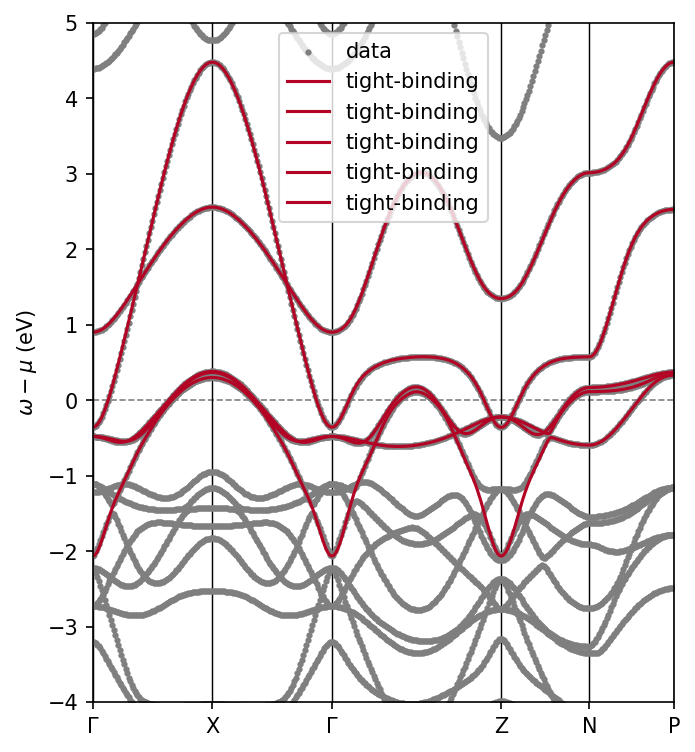

In [3]:
fig, ax = plt.subplots(1,dpi=150,figsize=(5,6))

# since every code uses a different scale for a k-path we have to scale the QE bands
factor = tb_bands_data['k_mesh'][-1]/band_data[-1,0]

# plot QE bands
ax.scatter(band_data[:,0] * factor, band_data[:,1] - fermi, color='C7', s=4, label='data')

# plot W90 bands using the plot_bands function of pcb
pcb.plot_bands(fig, ax, alatt_k_w_path, tb_bands_data, freq_dict, n_orb=w90_dict['n_orb'], dft_mu=0.0, tb=True, alatt=False, **plot_dict)

ax.set_ylim(-4,5)
ax.legend()
plt.show()

In [4]:
with HDFArchive('sfo/check/b30-U4.0-J0.75/sfo.h5','r') as h5:
    # the next two lines load all directly measured observables and the convergence metrics per iteration
    obs = h5['DMFT_results/observables']
    conv_obs = h5['DMFT_results/convergence_obs']
    # The next lines load the last iteration impurity Green function and self-energies
    Sigma_imp_iw = h5['DMFT_results/last_iter/Sigma_freq_0']
    G_imp_iw = h5['DMFT_results/last_iter/Gimp_freq_0']
    G_imp_tau_mc = h5['DMFT_results/last_iter/G_time_orig_0']
    G_imp_tau = h5['DMFT_results/last_iter/Gimp_time_0']
    G_imp_leg = h5['DMFT_results/last_iter/Gimp_l_0']
    # last, the chemical potential and double counting potential
    mu = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc = h5['DMFT_results']['last_iter']['DC_pot']
    # print(obs['mu'])

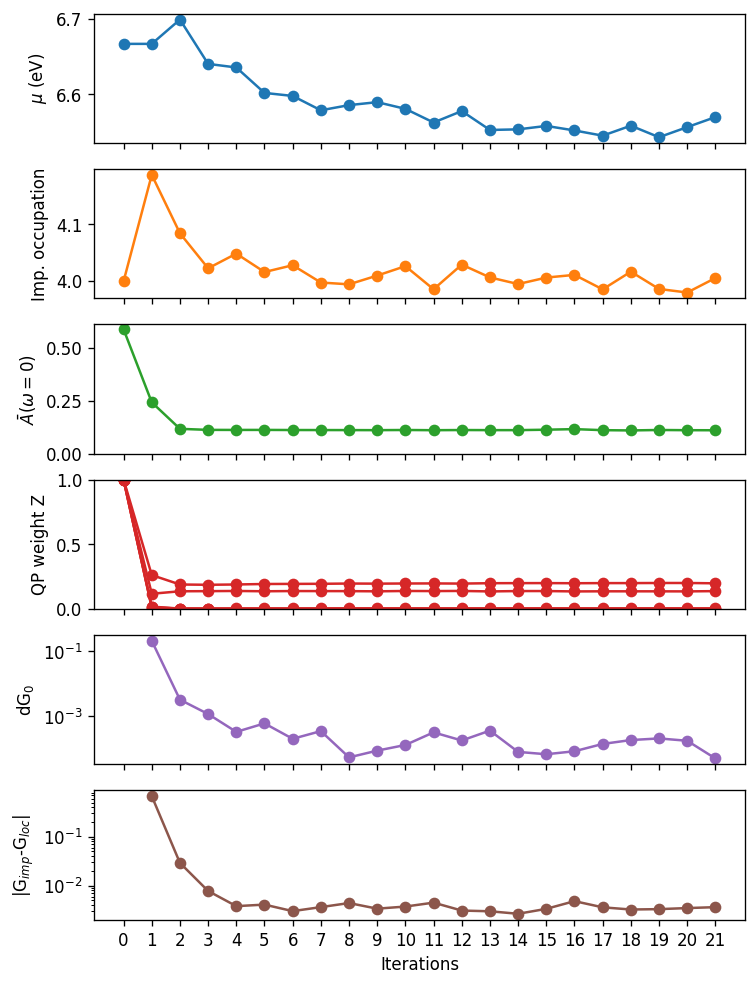

In [5]:
fig, ax = plt.subplots(nrows=6, dpi=120, figsize=(7,10), sharex=True)

# chemical potential
ax[0].plot(obs['iteration'], obs['mu'], '-o', color='C0')
ax[0].set_ylabel(r'$\mu$ (eV)')

# imp occupation
imp_occ = np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down'])
ax[1].plot(obs['iteration'], imp_occ, '-o', color='C1')
# ax[1].set_ylim(0.98,1.02)
# ax[1].set_ylim(1.9,2.1)
ax[1].set_ylabel('Imp. occupation')

# A(w=0)
Aw0 = -1*(np.array(obs['imp_gb2'][0]['up'])+np.array(obs['imp_gb2'][0]['down']))
ax[2].plot(obs['iteration'], Aw0 , '-o', color='C2')
ax[2].set_ylim(0,)
ax[2].set_ylabel(r'$\bar{A}(\omega=0$)')

# Z
Z = 0.5*(np.array(obs['orb_Z'][0]['up'])+np.array(obs['orb_Z'][0]['down']))
ax[3].plot(obs['iteration'], Z, '-o', color='C3')
ax[3].set_ylim(0,1.0)
ax[3].set_ylabel(r'QP weight Z')

# convergence of Weiss field
ax[4].semilogy(obs['iteration'][1:], conv_obs['d_G0'][0], '-o', color='C4')
ax[4].set_ylabel(r'dG$_0$')

# convergence of DMFT self-consistency condition Gimp-Gloc
ax[5].semilogy(obs['iteration'][1:], conv_obs['d_Gimp'][0], '-o', color='C5')
ax[5].set_ylabel(r'|G$_{imp}$-G$_{loc}$|')

ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')

plt.show()

In [6]:
print(Sigma_imp_iw['up_0'][0,0])

Greens Function  with mesh Matsubara Freq Mesh of size 2600, Domain: Matsubara domain with beta = 30, statistic = Fermion, positive_only : 0 and target_shape (): 



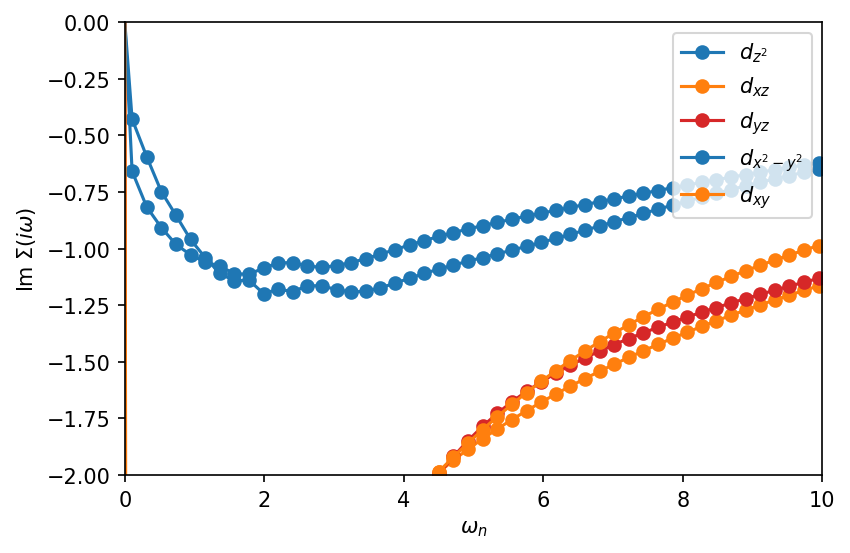

In [7]:
# plot self energy
fig, ax = plt.subplots(1, dpi=150)

ax.oplot(Sigma_imp_iw['up_0'][0,0].imag, '-o', c='C0', label='$d_{z^2}$')
ax.oplot(Sigma_imp_iw['up_0'][1,1].imag, '-o', c='C1', label='$d_{xz}$')
ax.oplot(Sigma_imp_iw['up_0'][2,2].imag, '-o', c='C3', label='$d_{yz}$')
ax.oplot(Sigma_imp_iw['up_0'][3,3].imag, '-o', c='C0', label='$d_{x^2-y^2}$')
ax.oplot(Sigma_imp_iw['up_0'][4,4].imag, '-o', c='C1', label='$d_{xy}$')

ax.set_ylabel(r"Im $\Sigma (i \omega)$")
ax.set_xlim(0,10)
ax.set_ylim(-2,0)
plt.show()

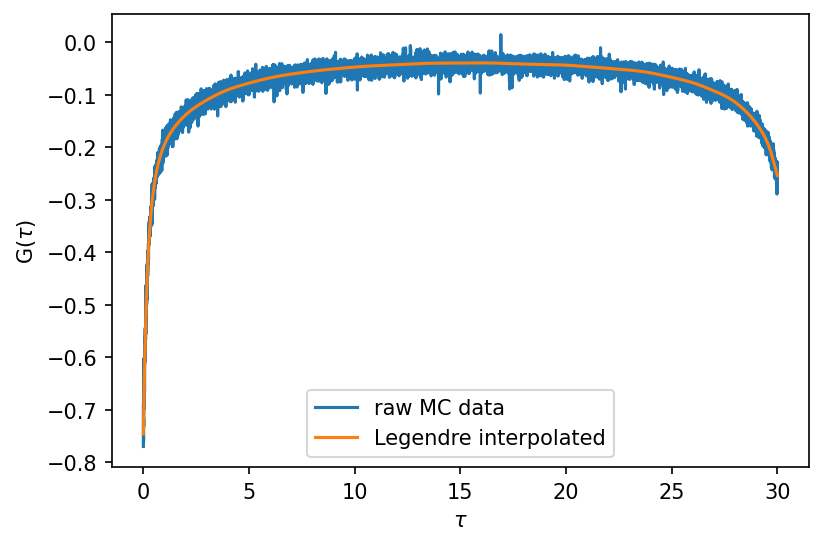

In [8]:
# plot self energy
fig, ax = plt.subplots(1, dpi=150)

ax.oplot(G_imp_tau_mc['up_0'][0,0].real, '-', c='C0', label='raw MC data')
ax.oplot(G_imp_tau['up_0'][0,0].real, '-', c='C1', label='Legendre interpolated')

ax.set_ylabel(r"G$ (\tau)$")

ax.legend(loc='lower center')
plt.show()

In [ ]:
# use pcb maxent script to continue sigma
Sigma_real_freq = sigma_maxent.main(external_path='sfo/check/b30-U4.0-J0.75/sfo.h5', 
                                     omega_min = -10, omega_max= 10, 
                                     maxent_error=0.03, iteration= None,
                                     n_points_maxent=101,
                                     continuator_type='inversion_dc')[0][0]

Finished reading h5 archive. Found 1 impurities.
Created sigma continuator of type "inversion_dc"
Starting run of maxent now.
Continuing impurities with blocks:
- Imp 0: ['up_0', 'down_0']
